In [1]:
import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"


In [9]:
import PIL
from PIL import Image
import requests
import torch
from io import BytesIO
import numpy as np 

from diffusers import DDIMScheduler, DDIMInverseScheduler,StableDiffusionPipeline 

In [3]:
class DDIMInversion():
    def __init__(self, pipe):
        # get params from DDIMScheduler
        self.pipe = pipe
        scheduler = DDIMInverseScheduler.from_config(pipe.scheduler.config)
        self.alphas_cumprod = scheduler.alphas_cumprod
        self.initial_alpha_cumprod = scheduler.initial_alpha_cumprod

        print(self.pipe.scheduler.config.clip_sample)

    def set_timesteps(self, target_timestep, num_inference_steps, device="cuda"):
        self.target_timestep = target_timestep
        self.num_inference_steps = num_inference_steps

        step_ratio = self.target_timestep // self.num_inference_steps
        timesteps = (np.arange(0, self.num_inference_steps) * step_ratio).round().copy().astype(np.int64) + 1

        timesteps = np.roll(timesteps, 1)
        timesteps[0] = int(timesteps[1] - step_ratio)
        self.timesteps = torch.from_numpy(timesteps).to(device)

    def step_ddim_inv(self, z, eps, timestep):
        prev_timestep = timestep + self.target_timestep // self.num_inference_steps

        alpha_prod_t = self.alphas_cumprod[timestep] if timestep >= 0 else self.initial_alpha_cumprod
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep]

        beta_prod_t = 1 - alpha_prod_t
        pred_original_sample = (z - beta_prod_t ** (0.5) * eps) / alpha_prod_t ** (0.5)
        pred_sample_direction = (1 - alpha_prod_t_prev) ** (0.5) * eps
        prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

        return prev_sample

    def __call__(self, z, embedd, target_timestep, num_inference_steps, guidance_scale=1, device="cuda"):
        self.set_timesteps(target_timestep, num_inference_steps, device=device)
        z_t = z.clone()
        with torch.no_grad():
            for timestep in self.timesteps:
                eps = self.pipe.unet(z_t, timestep, embedd).sample
                z_t = self.step_ddim_inv(z_t, eps, timestep)

        return z_t, eps

In [4]:
device='cuda'
target_timestep = 1000
num_inference_steps = 50

In [5]:
sd_pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
)
sd_pipe.enable_model_cpu_offload()
sd_pipe = sd_pipe.to(device)

/home/vll/venv_pytorch2.0/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, tokenizer, unet, scheduler, safety_checker, feature_extractor to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.


In [11]:
@torch.no_grad()
def get_text_embeddings(pipe: StableDiffusionPipeline, text: str, device="cuda"):
    tokens = pipe.tokenizer(
        [text],
        padding="max_length",
        max_length=77,
        truncation=True,
        return_tensors="pt",
        return_overflowing_tokens=True,
    ).input_ids.to(device)
    return pipe.text_encoder(tokens).last_hidden_state.detach()

In [7]:
def load_512(image_path: str, left=0, right=0, top=0, bottom=0):
    image = np.array(Image.open(image_path))[:, :, :3]
    h, w, c = image.shape
    left = min(left, w - 1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top : h - bottom, left : w - right]
    h, w, c = image.shape
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset : offset + h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset : offset + w]
    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image

In [12]:
image = load_512("origin.png")
image_source = torch.from_numpy(image).float().permute(2, 0, 1) / 127.5 - 1
image_source = image_source.unsqueeze(0).to(device).half()
with torch.no_grad():
    z = sd_pipe.vae.encode(image_source)["latent_dist"].mean * 0.18215
ddim_inversion = DDIMInversion(sd_pipe)

False


  0%|          | 0/999 [00:00<?, ?it/s]

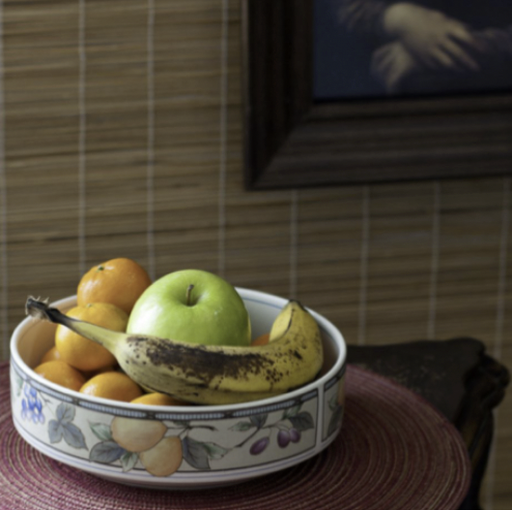

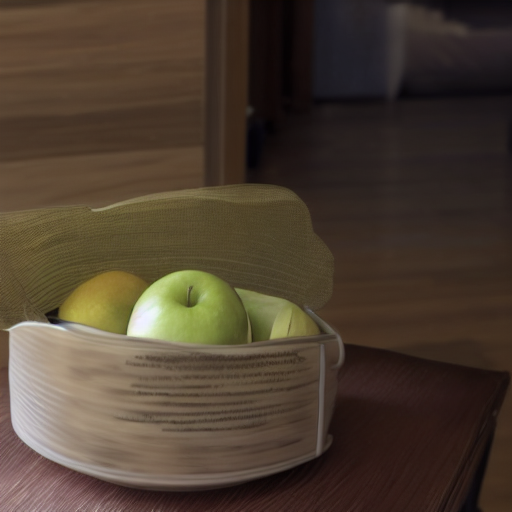

In [14]:


num_inference_steps_invert = 50
num_inference_steps = num_inference_steps_invert
mask_prompt = "A bowl of fruits"
embedd = get_text_embeddings(sd_pipe, mask_prompt, device=device)
z_t, _ = ddim_inversion(z, embedd, target_timestep, num_inference_steps_invert, device=device, guidance_scale=1)

sd_pipe.scheduler = DDIMScheduler.from_config(sd_pipe.scheduler.config, subfolder='scheduler')
def dummy(images, **kwargs):
    return images, None
sd_pipe.safety_checker = dummy  
seed = 0
generator = torch.Generator(device=device).manual_seed(seed)
image = sd_pipe(
    prompt=mask_prompt,
    negative_prompt="",
    guidance_scale=1,
    num_inference_steps=num_inference_steps, 
    latents=z_t,
    generator=generator
)
display(Image.open("origin.png"))
display(image[0][0])